# Bubble Analysis

## Abstract

Analyze Hass Door part numbers of complete doors where at least one section presented a buble caused by the expansion of gas trapped between the exterior skin and foam.

## Data

Data will be imported from Microsoft Excel files in the following format:

![alt text](assets/image.png)

The file can contain multiple sheets and all sheets will be imported and concatinated if `use_all_sheets = True`.

Columns can be added to the data by modifying `columns = ['Line', 'Blend','EndOfPourTimeStamp', 'SmartPartNumber', 'Order Number']`.

### Open XLSX and Convert to CSV


In [1]:
import xlsx_to_csv as xtc

files = ['order_history_small.xlsx', 'orders_with_bubbles.xlsx', 'sections_with_bubbles.xlsx']
columns = ['Order', 'Serial', 'SmartPartNumber', 'Line', 'Blend', 'EndOfPourTimeStamp']
overwrite_existing = True
use_all_sheets = True

# convert the XLSX file to CSV
for file in files:
    csv_file = xtc.xls_to_csv(file, columns, overwrite_existing, use_all_sheets)

order_history_small.csv has been created.
orders_with_bubbles.csv has been created.
sections_with_bubbles.csv has been created.


In [ ]:
import pandas as pd
import haas_section as hs
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("Loading data . . .")
df = pd.read_csv('order_history.csv')
df_owb = pd.read_csv('orders_with_bubbles.csv')
df_swb = pd.read_csv('sections_with_bubbles.csv')

# Add column to indicate that at least one section
# on the order had a bubble
df_owb['Bubble on Order']= True
df_owb['Bubble on Order'] = df_owb['Bubble on Order'].astype(bool)
df_owb = df_owb[['Order','Bubble on Order']]

# Add column to indicate that the section as a bubble
df_swb['Bubble']=  True
df_swb['Bubble'] = df_swb['Bubble'].astype(bool)
df_swb = df_swb[['Serial', 'Bubble']]

bubble_list = df_swb['Serial'].values.tolist()
count = df['Serial'].isin(bubble_list).sum()

print(f'There are {count} of {len(bubble_list)} sections in the master list.')

# Merge orders with bubbles that includes 
# 'Bubble on Order' bool to all orders
df = pd.merge(df, df_owb, how='outer', on='Order')


# Merge sections with bubbles that includes 
# 'Bubble' bool to all orders
df = pd.merge(df, df_swb, how='outer', on='Serial')

# Fill in the False values
df['Bubble'] = df['Bubble'].fillna(False)
df['Bubble on Order'] = df['Bubble on Order'].fillna(False)
df.loc[df['Bubble'], 'Bubble on Order'] = True

# df_no_order = df_merged[df_merged['Order'].isnull()]

# disect the part number and make columns for each definition
for option, loc in hs.ht_part_number.items():
    df[option] = df['SmartPartNumber'].str[loc[0]:loc[1]]

# df.to_csv("bubbles.csv")

# # convert EndOfPourTimeStamp into date/time object
# # then make Year, Month and Day and Hour columns
df['EndOfPourTimeStamp'] = pd.to_datetime(df['EndOfPourTimeStamp'])
df['EndOfPourTimeStamp'] = df['EndOfPourTimeStamp'].dt.round(freq='15min')
df['Weekday'] = df['EndOfPourTimeStamp'].dt.weekday
df['Year'] = df['EndOfPourTimeStamp'].dt.year
df['Month'] = df['EndOfPourTimeStamp'].dt.month
df['Hour'] = df['EndOfPourTimeStamp'].dt.hour
# df['Time'] = df['EndOfPourTimeStamp'].dt.time

firstDate, lastDate = df['EndOfPourTimeStamp'].min(), df['EndOfPourTimeStamp'].max()
print(f'From {firstDate} to {lastDate}')

# delete the original EndOfPourTimeStamp 
df.drop('EndOfPourTimeStamp', axis=1, inplace=True)
# delete the SmartPartNumber 
df.drop('SmartPartNumber', axis=1, inplace=True)
# delete the Order Number 
df.drop('Order', axis=1, inplace=True)
# delete the Serial Number 
df.drop('Serial', axis=1, inplace=True)

df_shape = df.shape
df.dropna(inplace=True)
df_new_shape = df.shape

dropped_rows = df_shape[0] - df_new_shape[0]
print(f'*{dropped_rows} rows were dropped due to incomplete data.')

# remove uniform columns
uniform_columns = [col for col in df.columns if df[col].nunique() == 1]
print(str(uniform_columns) + " contain homogeneous data and have been removed.")
df = df.drop(columns=uniform_columns)

df.to_csv("bubbles.csv")

# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to all categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Calculate Pearson correlation (default)
pearson_corr = df.corr()

# Calculate Spearman correlation
spearman_corr = df.corr(method='spearman')

# Calculate Kendall correlation
kendall_corr = df.corr(method='kendall')

correlation_matrix = pearson_corr

# Print the correlation matrix
print(correlation_matrix)

Loading data . . .
There are 0 of 61 sections in the master list.
From 2024-01-16 03:15:00 to 2024-07-30 00:45:00
*5506 rows were dropped due to incomplete data.
['Bubble on Order', 'Bubble', 'Outside Skin', 'Inside Grooving', 'Year'] contain homogeneous data and have been removed.
                            Line     Blend      Type    Height  Construction  \
Line                    1.000000 -0.311872 -0.040772  0.302485      0.056589   
Blend                  -0.311872  1.000000  0.034343  0.147794     -0.773646   
Type                   -0.040772  0.034343  1.000000 -0.038094      0.089168   
Height                  0.302485  0.147794 -0.038094  1.000000     -0.125146   
Construction            0.056589 -0.773646  0.089168 -0.125146      1.000000   
Color                  -0.419601  0.025968  0.123236 -0.245164      0.033704   
Thickness              -0.109581  0.781543 -0.104584  0.252570     -0.658587   
Outside Treatment       0.652119 -0.041406  0.060985  0.242804      0.073922 

C:\Users\mrupp\AppData\Local\Temp\ipykernel_27000\3648640138.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bubble'] = df['Bubble'].fillna(False)
C:\Users\mrupp\AppData\Local\Temp\ipykernel_27000\3648640138.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bubble on Order'] = df['Bubble on Order'].fillna(False)


The correlation matrix will contain the Pearson correlation coefficients between each pair of variables. A value closer to 1 indicates a strong positive relationship, while values closer to -1 indicate a strong negative relationship. Values close to zero suggest no linear relationship between two variables.


In [18]:
# Identify the most correlated variables
most_correlated_variables = correlation_matrix.unstack().sort_values(ascending=False)[1:]

# Print the most correlated variables
print('Most correlated variables:')
print(most_correlated_variables)

Most correlated variables:
Serial                  Serial                    1.0
Backer Stile Placement  Backer Stile Placement    1.0
EndOfPourTimeStamp      EndOfPourTimeStamp        1.0
Inside Skin             Inside Skin               1.0
Length                  Length                    1.0
                                                 ... 
Weekday                 Bubble                    NaN
Month                   Bubble on Order           NaN
                        Bubble                    NaN
Hour                    Bubble on Order           NaN
                        Bubble                    NaN
Length: 483, dtype: float64


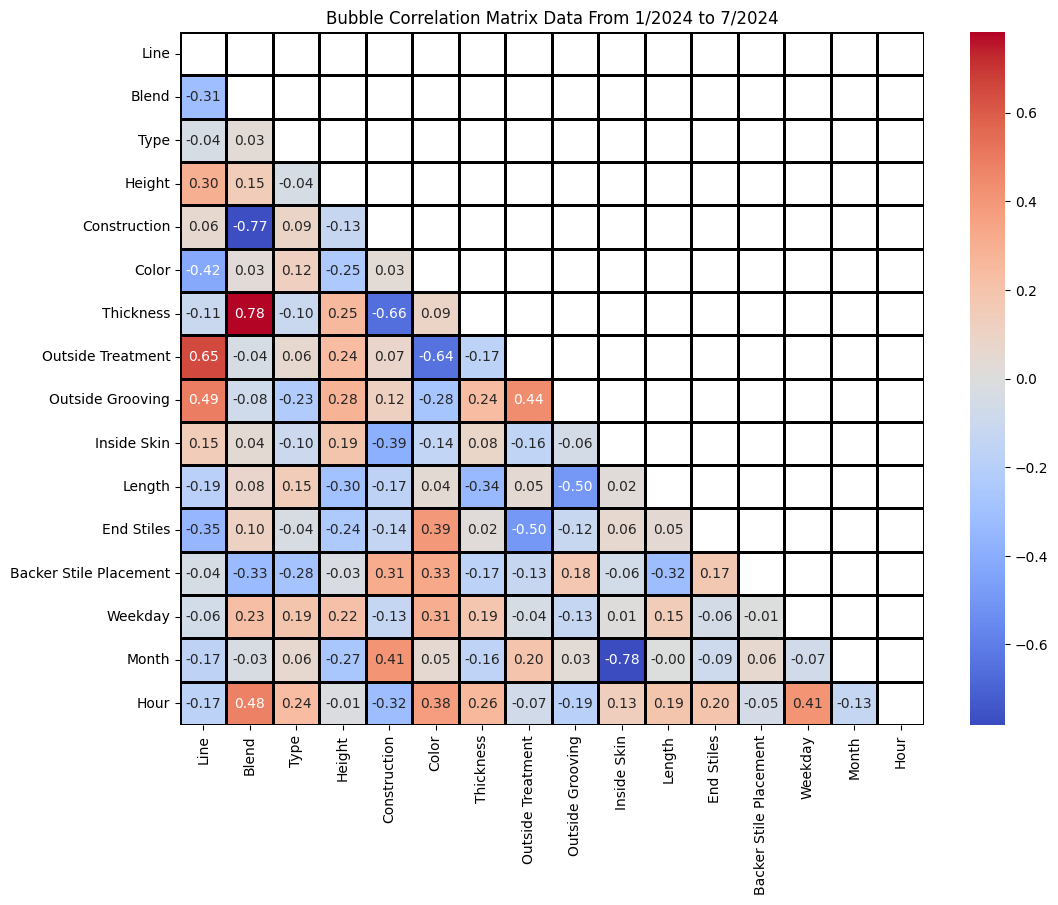

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 9))
matrix = np.triu(df.corr())
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            cbar=True, 
            fmt=".2f",
            center=0,
            linewidths=2, 
            linecolor='black',
            mask=matrix
            )

# Add a title
plt.title(f'Bubble Correlation Matrix Data From {firstDate.month}/{firstDate.year} to {lastDate.month}/{lastDate.year}')

# Show the plot
plt.show()

In [5]:
pd.unique(df['Color'])

pd.value_counts(df['Color'])



C:\Users\mrupp\AppData\Local\Temp\ipykernel_27532\1050050563.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['Color'])


Color
2    35
5    14
0     9
4     8
3     7
1     4
6     1
Name: count, dtype: int64

In [9]:
import pandas as pd

print(df['Color'])

# Label encoding
df['encoded_Color'] = df['Color'].astype('category').cat.codes

# Create a mapping dictionary
mapping = dict(enumerate(df['Color'].astype('category').cat.categories))

# Reverse the encoding
df['decoded_color'] = df['encoded_Color'].map(mapping)

print(df)

0        3
1        3
2        3
3        3
4        3
        ..
5440    15
5441    15
5442    15
5443    15
5444    15
Name: Color, Length: 5445, dtype: int64
      Line  Blend  Type  Height  Construction  Color  Thickness  Outside Skin  \
0        1      7     0       2             4      3          2             0   
1        1      7     1       2             4      3          2             0   
2        1      7     1       2             4      3          2             0   
3        1      7     1       2             4      3          2             0   
4        1      7     1       2             4      3          2             0   
...    ...    ...   ...     ...           ...    ...        ...           ...   
5440     1     16     1       2             0     15          0             0   
5441     1     16     1       2             0     15          0             0   
5442     1     16     1       2             0     15          0             0   
5443     1     16     1      